In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.spatial import distance

In [21]:
df = pd.read_csv('datasets/dataset.csv')

df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Data Preprocessing

In [22]:
df.shape

(114000, 20)

In [23]:
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 450 rows that are duplicated so we need to drop those 450 rows
After drop duplicated rows, there are 113550 rows left


In [24]:
df.dtypes.to_frame('Data Type')

,Data Type
track_id,object
artists,object
album_name,object
track_name,object
popularity,int64
duration_ms,int64
explicit,bool
danceability,float64
energy,float64
key,int64


In [25]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return dtypes

obj_cols = df.select_dtypes(include='object').columns
df[obj_cols].apply(open_object_dtype, axis=0).to_frame('Data Type')

,Data Type
track_id,{<class 'str'>}
artists,"{<class 'float'>, <class 'str'>}"
album_name,"{<class 'float'>, <class 'str'>}"
track_name,"{<class 'float'>, <class 'str'>}"
track_genre,{<class 'str'>}


In [28]:
missing_values_per_row = df.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()
# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')
    
total_rows_with_missing_values = (df.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

113549 row(s) have 0 missing values
1 row(s) have 3 missing values
Total number of rows with missing values: 1


# Data Distribution

In [29]:
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]
numerical_cols.shape

(113550, 14)

In [30]:
numerical_cols.sample(5)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
32031,73,212500,0.842,0.801,8,-4.167,0,0.2280,0.157000,0.000005,0.0642,0.6170,95.881,4
104805,55,313173,0.674,0.181,8,-11.073,1,0.0365,0.260000,0.000029,0.1120,0.0919,114.937,4
55650,46,211787,0.718,0.678,6,-11.895,1,0.2200,0.485000,0.001900,0.1020,0.4720,181.880,4
84844,27,202586,0.405,0.954,1,-4.183,0,0.0600,0.000187,0.000005,0.1000,0.7590,134.510,4
66400,35,255613,0.845,0.692,2,-4.938,1,0.0448,0.209000,0.000000,0.7150,0.6610,120.051,4


In [31]:
numerical_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113550 entries, 0 to 113999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        113550 non-null  int64  
 1   duration_ms       113550 non-null  int64  
 2   danceability      113550 non-null  float64
 3   energy            113550 non-null  float64
 4   key               113550 non-null  int64  
 5   loudness          113550 non-null  float64
 6   mode              113550 non-null  int64  
 7   speechiness       113550 non-null  float64
 8   acousticness      113550 non-null  float64
 9   instrumentalness  113550 non-null  float64
 10  liveness          113550 non-null  float64
 11  valence           113550 non-null  float64
 12  tempo             113550 non-null  float64
 13  time_signature    113550 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 13.0 MB


In [32]:
dist_numerical_cols = numerical_cols.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = numerical_cols.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (numerical_cols.isnull().mean() * 100).round(2)
# The number of -1 values in the 'key' column
dist_numerical_cols.loc['key', 'Missing Values'] = (df['key'] == -1).sum()
dist_numerical_cols

,min,max,Missing Values,Missing Percentage
popularity,0.000,100.000,0,0.0
duration_ms,0.000,5237295.000,0,0.0
danceability,0.000,0.985,0,0.0
energy,0.000,1.000,0,0.0
key,0.000,11.000,0,0.0
loudness,-49.531,4.532,0,0.0
mode,0.000,1.000,0,0.0
speechiness,0.000,0.965,0,0.0
acousticness,0.000,0.996,0,0.0
instrumentalness,0.000,1.000,0,0.0


In [33]:
numerical_cols.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113550.000000,1.135500e+05,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000
mean,33.324139,2.280794e+05,0.567031,0.642090,5.309467,-8.243419,0.637860,0.084674,0.314067,0.155702,0.213611,0.474207,122.175888,3.904218
std,22.283976,1.064148e+05,0.173408,0.251052,3.560134,5.011401,0.480621,0.105761,0.331907,0.309216,0.190461,0.259204,29.972861,0.432115
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.741802e+05,0.456000,0.473000,2.000000,-9.997750,0.000000,0.035900,0.016800,0.000000,0.098000,0.260000,99.296500,4.000000
50%,35.000000,2.130000e+05,0.580000,0.685000,5.000000,-6.997000,1.000000,0.048900,0.168000,0.000041,0.132000,0.464000,122.020000,4.000000
75%,50.000000,2.615878e+05,0.695000,0.854000,8.000000,-5.001000,1.000000,0.084500,0.596000,0.048675,0.273000,0.683000,140.073750,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


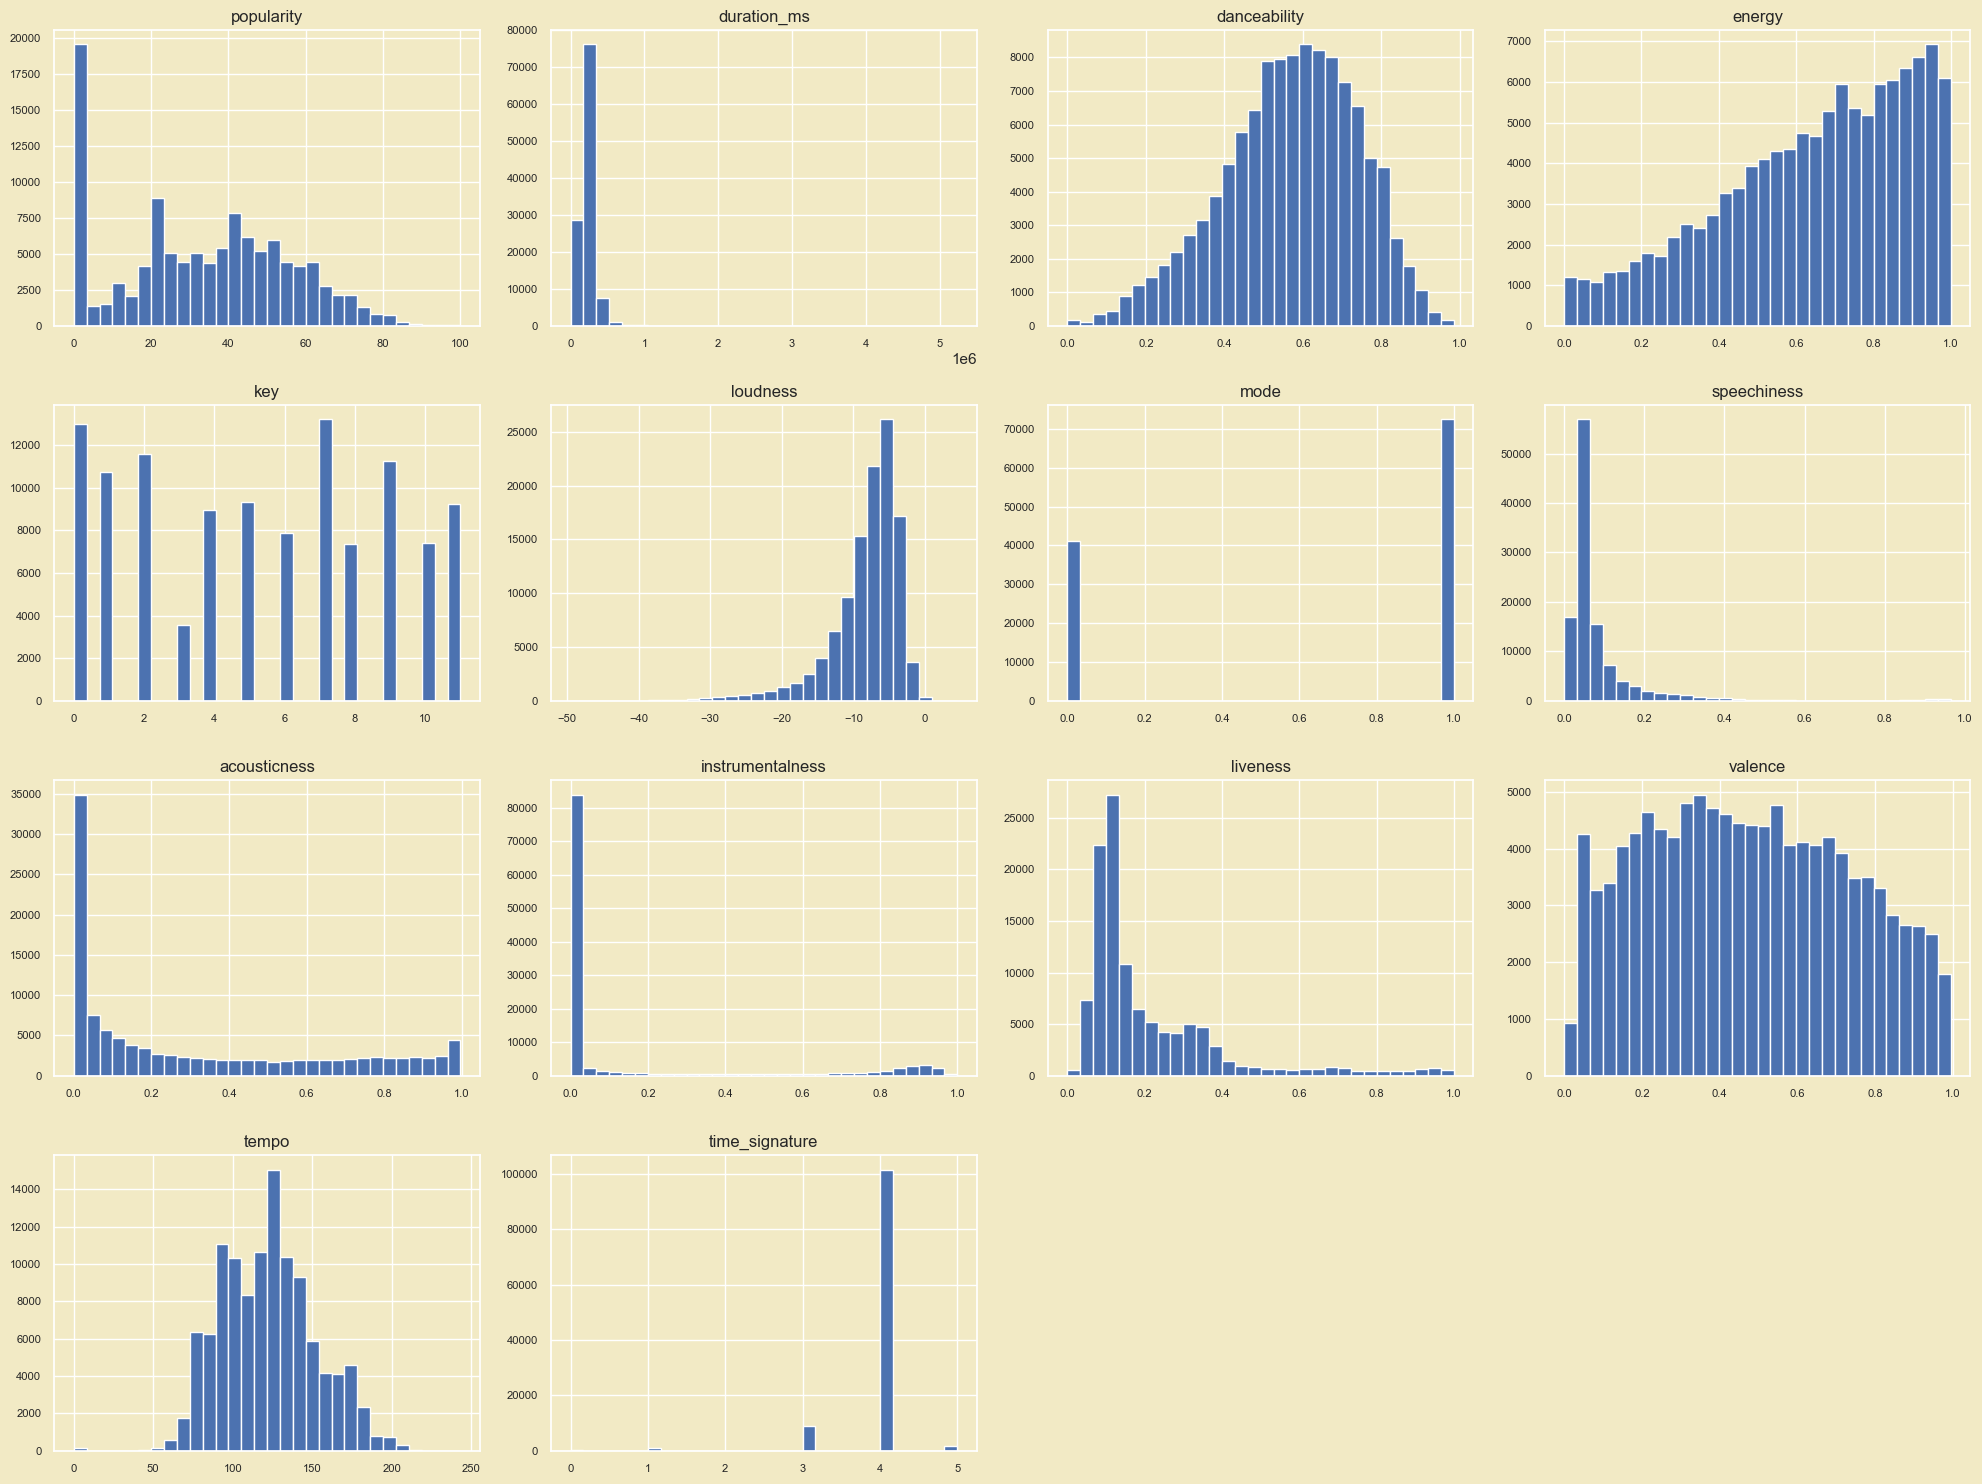

In [34]:
#Distribution of numerical columns
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [37]:
categorical_cols = df[df.columns[(df.dtypes == 'object') | (df.dtypes == 'bool')]]
categorical_cols.shape

(113550, 6)

In [38]:
categorical_cols.sample(5)

,track_id,artists,album_name,track_name,explicit,track_genre
103542,2vVVKj5p0Lb3Kc3Grs37Ls,James Brown,A Very 60s Christmas,Santa Claus Go Straight To The Ghetto,False,soul
21212,3ketN3dth18vSJ1T3HIztN,Burna Boy;Wizkid,B. D’OR (feat. Wizkid),B. D’OR (feat. Wizkid),False,dancehall
37165,6E23vNBxAqr0lF60IvAv3j,Clean Bandit;Topic;Wes Nelson,Today's Party Hits,Drive,False,funk
57095,2jQQTuzwJWEtwayffAADIe,Pranav Das,Pagal Iravai | Maraigirai,Pagal Iravai | Maraigirai,False,indie
13626,6tXhW3RvKa5md44T7446Tw,Frankie Knuckles;Director's Cut;Eric Kupper;Ja...,Baby Wants to Ride (Re-Directed),Baby Wants to Ride - Re-Directed,True,chicago-house


In [39]:
categorical_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113550 entries, 0 to 113999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   track_id     113550 non-null  object
 1   artists      113549 non-null  object
 2   album_name   113549 non-null  object
 3   track_name   113549 non-null  object
 4   explicit     113550 non-null  bool  
 5   track_genre  113550 non-null  object
dtypes: bool(1), object(5)
memory usage: 5.3+ MB


In [40]:
dist_categorical_cols = pd.DataFrame(
    data = {
        'Missing Values': categorical_cols.isnull().sum(),
        'Missing Percentage': (categorical_cols.isnull().mean() * 100)
    }
)
dist_categorical_cols

,Missing Values,Missing Percentage
track_id,0,0.000000
artists,1,0.000881
album_name,1,0.000881
track_name,1,0.000881
explicit,0,0.000000
track_genre,0,0.000000


In [41]:
categorical_cols[categorical_cols.isnull().any(axis=1)]

,track_id,artists,album_name,track_name,explicit,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,False,k-pop


In [42]:
index_to_drop = df[categorical_cols.isnull().any(axis=1)].index
df.drop(index_to_drop, inplace=True)

print(f'Rows with missing values dropped. Updated DataFrame shape: {df.shape}')

Rows with missing values dropped. Updated DataFrame shape: (113549, 20)


In [43]:
df.describe(include=['object', 'bool'])

,track_id,artists,album_name,track_name,explicit,track_genre
count,113549,113549,113549,113549,113549,113549
unique,89740,31437,46589,73608,2,114
top,6S3JlDAGk3uu3NtZbPnuhS,The Beatles,Alternative Christmas 2022,Run Rudolph Run,False,acoustic
freq,9,279,195,151,103831,1000


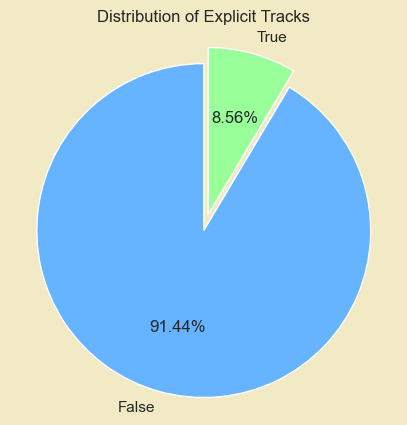

In [44]:
unique_values, value_counts = np.unique(categorical_cols['explicit'], return_counts=True)

fig, ax = plt.subplots(figsize=(5, 5))

# Explode the slice with explicit tracks for emphasis
explode = [0, 0.1]  # Only "yes" (true) will be slightly exploded
colors = ['#66b3ff','#99ff99']

ax.pie(value_counts, labels=unique_values, autopct='%1.2f%%', startangle=90, colors=colors, explode=explode)
ax.axis('equal')
ax.set_title('Distribution of Explicit Tracks')
plt.show()

###  Top of artists, album_name, track_name, track_genre

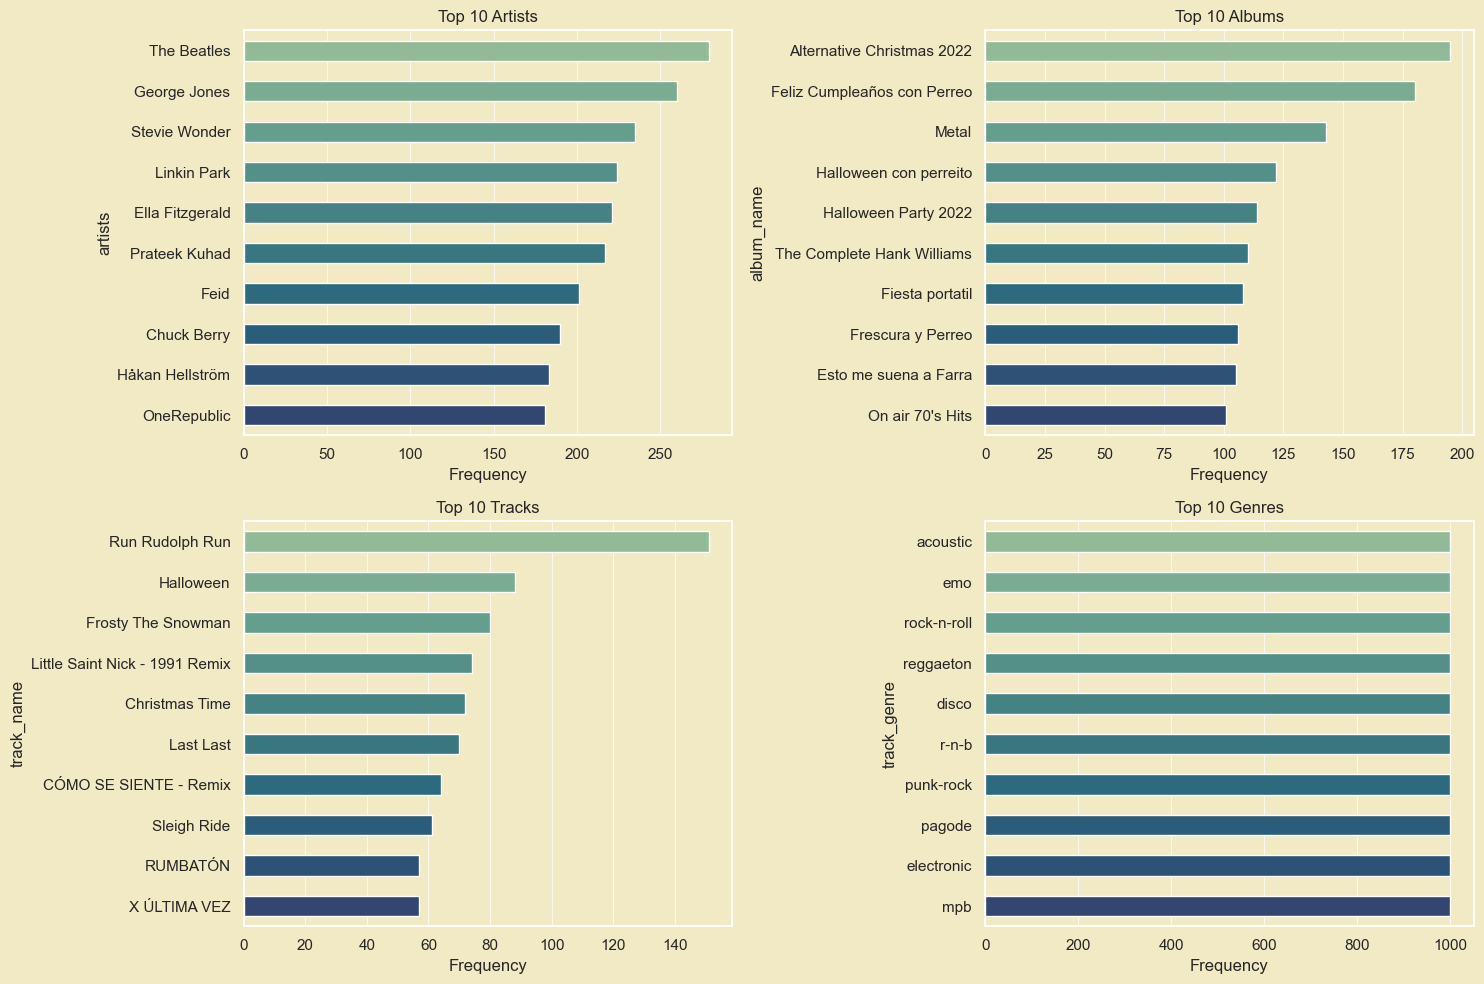

In [45]:
top_n = 10
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
# Get the top N most frequent artists, albums, tracks, and genres
top_artists = df['artists'].value_counts().head(top_n)
top_albums = df['album_name'].value_counts().head(top_n)
top_tracks = df['track_name'].value_counts().head(top_n)
top_genres = df['track_genre'].value_counts().head(top_n)

# Disable FutureWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Top N Artists
    sns.barplot(x=top_artists.values, y=top_artists.index, palette="crest", ax=axes[0, 0], orient='h',  zorder=3, width=0.5)
    axes[0, 0].set_title(f'Top {top_n} Artists')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Albums
    sns.barplot(x=top_albums.values, y=top_albums.index, palette="crest", ax=axes[0, 1], orient='h', zorder=3, width=0.5)
    axes[0, 1].set_title(f'Top {top_n} Albums')
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Tracks
    sns.barplot(x=top_tracks.values, y=top_tracks.index, palette="crest", ax=axes[1, 0], orient='h', zorder=3, width=0.5)
    axes[1, 0].set_title(f'Top {top_n} Tracks')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Genres
    sns.barplot(x=top_genres.values, y=top_genres.index, palette="crest", ax=axes[1, 1], orient='h', zorder=3, width=0.5)
    axes[1, 1].set_title(f'Top {top_n} Genres')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    plt.tight_layout()
    plt.show()

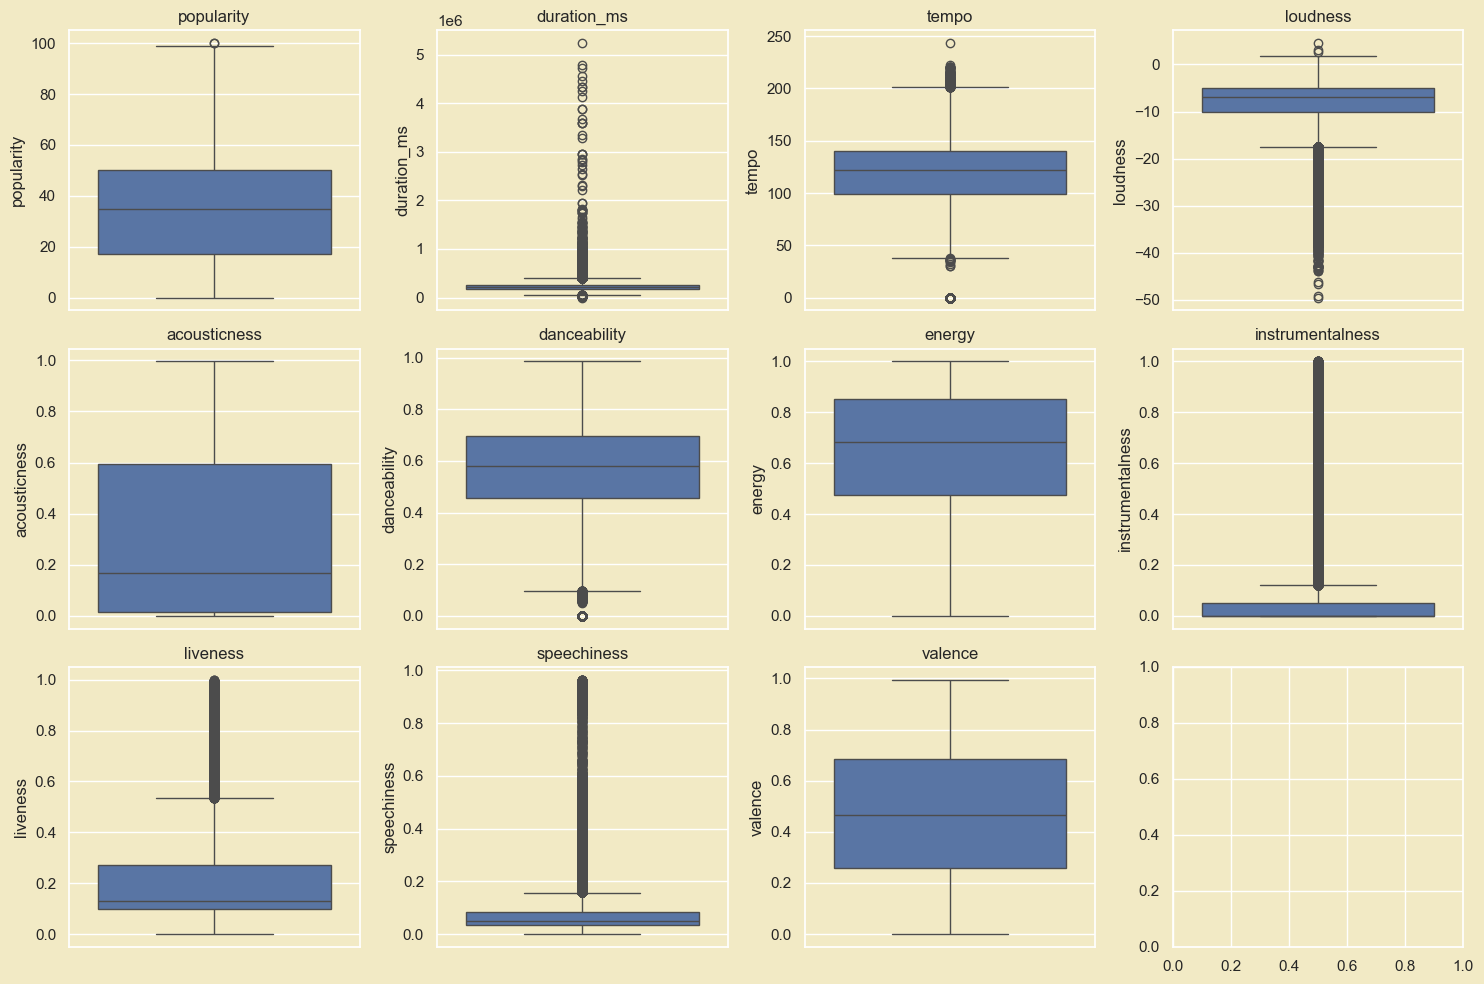

In [46]:
# boxplot for numerical columns
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
columns = ['popularity', 'duration_ms', 'tempo', 'loudness', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for i, col in enumerate(columns):
    sns.boxplot(y=col, data=numerical_cols, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
plt.tight_layout()
plt.show()

### Correlation Between Variables

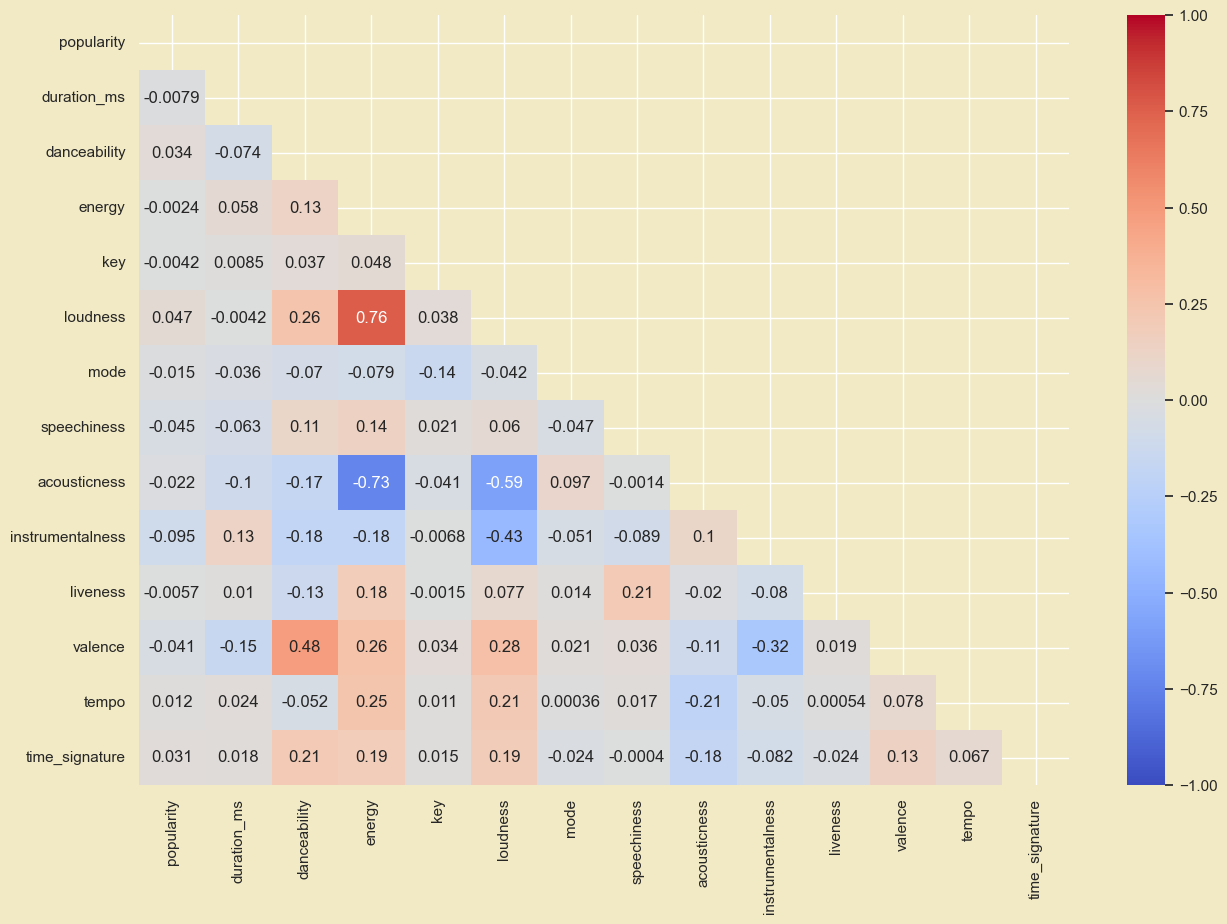

In [47]:
# heatmap for correlation
corr = numerical_cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_style('white')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1,cmap='coolwarm')
plt.show()

# Q1: How do different genre-related characteristics affect the popularity of songs?

## Approach: Analyze genre-related charactertistics:

- Number of songs for each genre
- Average popularity score for each genre.
- Explicit ratio.
- Genres in the top ~110 most popular songs.
- Ratio of live songs for each genre.
- Comparing the correlation between loudness and energy in the top 3 most popular genres

In [48]:
unique_genres = df['track_genre'].unique()
print(len(unique_genres))

114


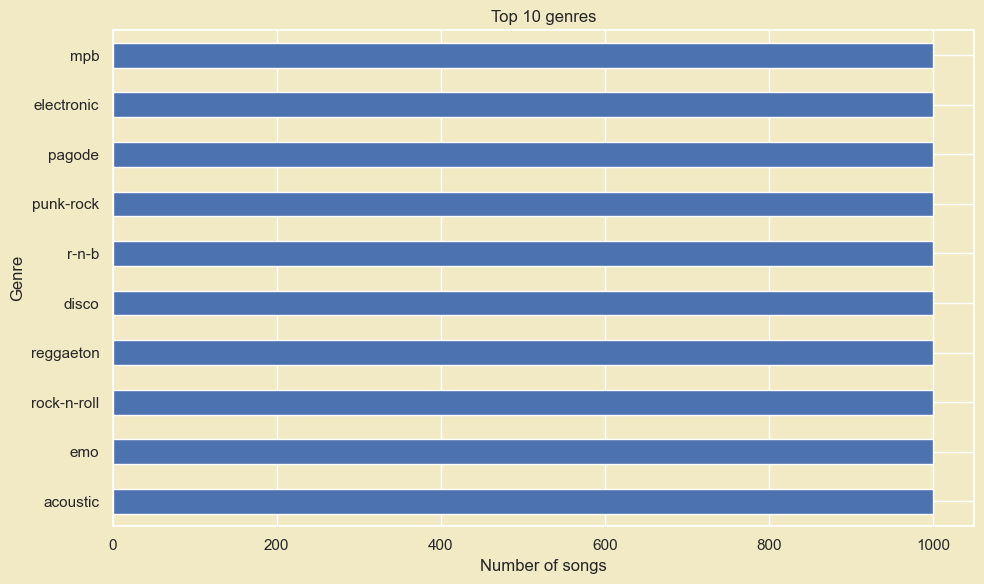

In [49]:
genre_counts = df['track_genre'].value_counts()
top_10_genres = genre_counts.head(10)

plt.figure(figsize=(10, 6))
top_10_genres.plot(kind='barh')
plt.title('Top 10 genres')
plt.xlabel('Number of songs')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

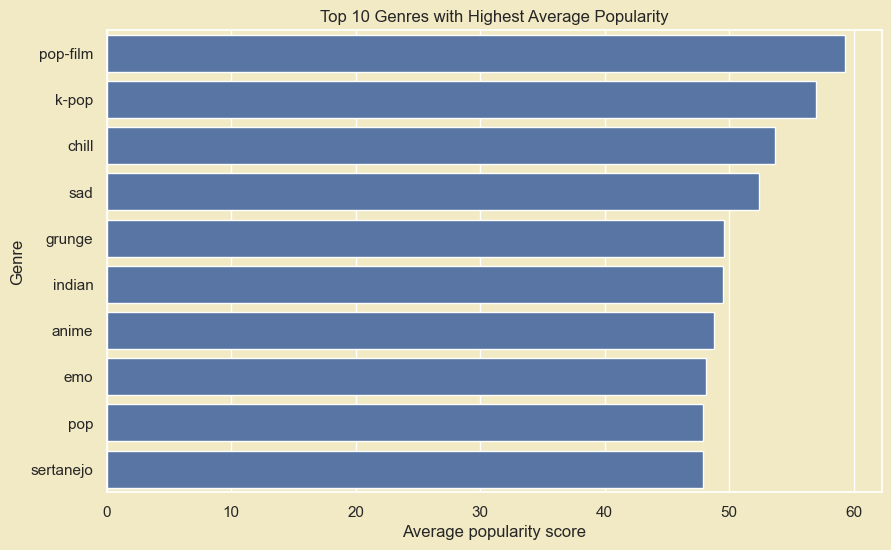

In [50]:
avg_popularity_by_genre = df.groupby('track_genre')['popularity'].mean().reset_index()
top10_popular_genres = avg_popularity_by_genre.nlargest(10, 'popularity')

plt.figure(figsize=(10, 6))
sns.barplot(x='popularity', y='track_genre', data=top10_popular_genres)
plt.title('Top 10 Genres with Highest Average Popularity')
plt.xlabel('Average popularity score')
plt.ylabel('Genre')
plt.show()

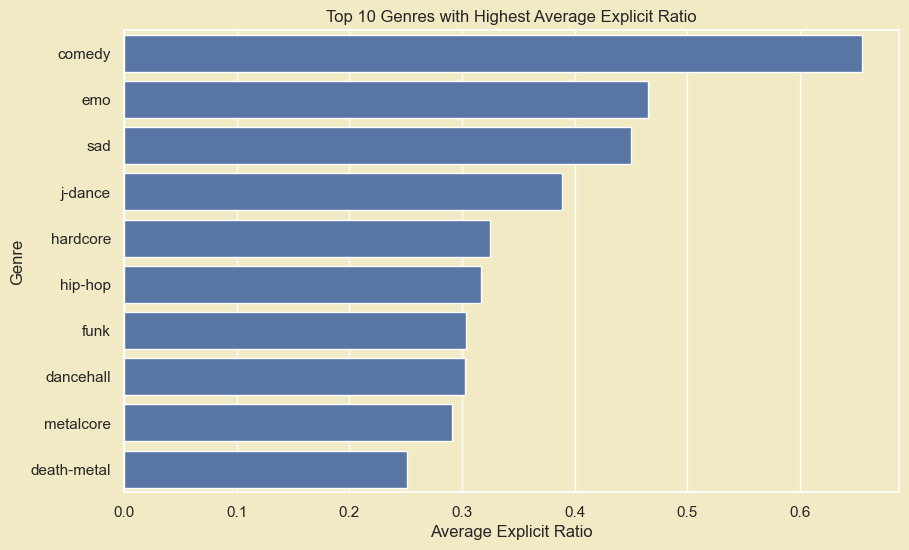

In [51]:
explicit_ratio_by_genre = df.groupby('track_genre')['explicit'].mean().reset_index()
top5_explicit_genres = explicit_ratio_by_genre.nlargest(10, 'explicit')

plt.figure(figsize=(10, 6))
sns.barplot(x='explicit', y='track_genre', data=top5_explicit_genres)
plt.title('Top 10 Genres with Highest Average Explicit Ratio')
plt.xlabel('Average Explicit Ratio')
plt.ylabel('Genre')
plt.show()

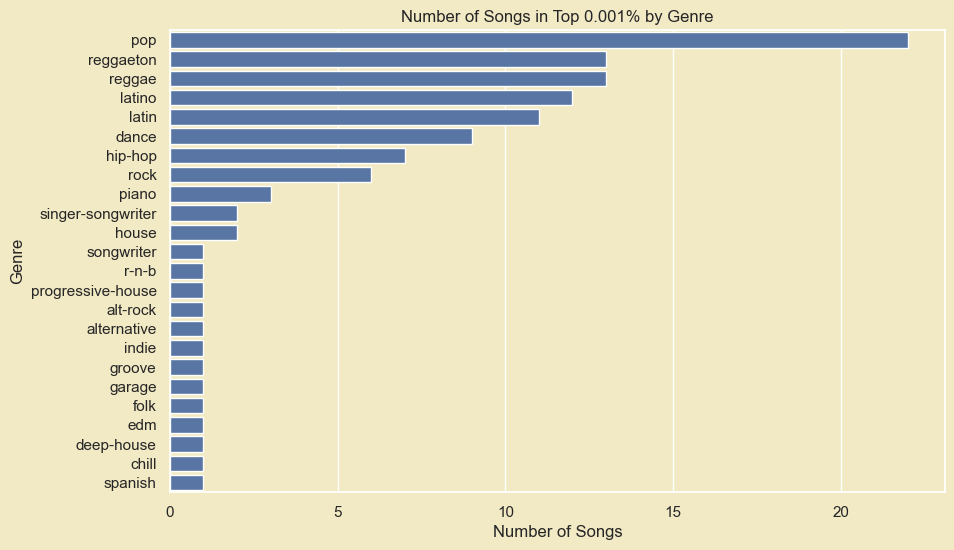

The genre with the most songs in the top 0.001% is pop with 22 songs.


In [53]:
df_sorted = df.sort_values(by='popularity', ascending=False)

top_10_percent = df_sorted.head(int(0.001 * len(df_sorted)))

top_genres_count = top_10_percent.groupby('track_genre').size().reset_index(name='count')
top_genres_count = top_genres_count.sort_values(by='count', ascending=False)

most_common_genre = top_genres_count.loc[top_genres_count['count'].idxmax()]

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='track_genre', data=top_genres_count)
plt.title('Number of Songs in Top 0.001% by Genre')
plt.xlabel('Number of Songs')
plt.ylabel('Genre')
plt.show()

print(f"The genre with the most songs in the top 0.001% is {most_common_genre['track_genre']} with {most_common_genre['count']} songs.")

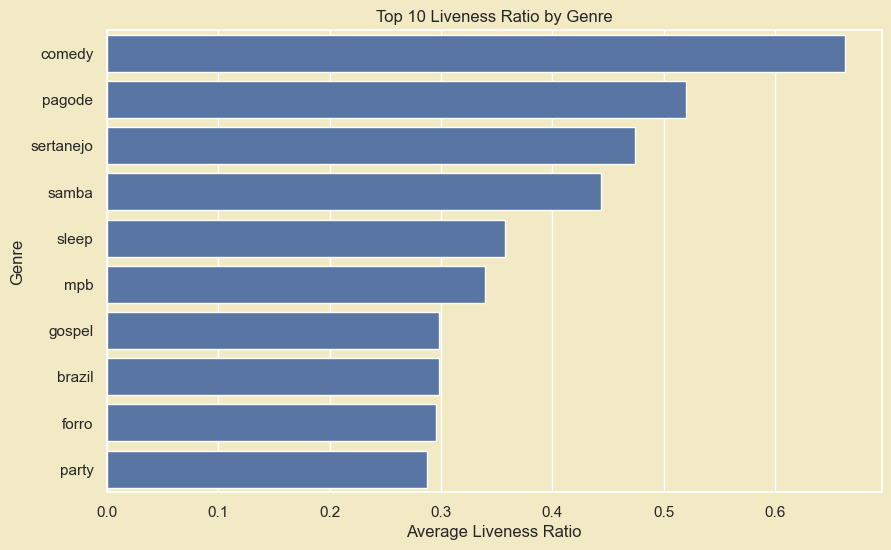

The genre with the highest liveness ratio is comedy with an average liveness ratio of 66.22%.


In [54]:
live_ratio_by_genre = df.groupby('track_genre')['liveness'].mean().reset_index()

top10_live_genres = live_ratio_by_genre.nlargest(10, 'liveness')
most_live_genre = live_ratio_by_genre.loc[live_ratio_by_genre['liveness'].idxmax()]

plt.figure(figsize=(10, 6))
sns.barplot(x='liveness', y='track_genre', data=top10_live_genres)
plt.title('Top 10 Liveness Ratio by Genre')
plt.xlabel('Average Liveness Ratio')
plt.ylabel('Genre')
plt.show()
print(f"The genre with the highest liveness ratio is {most_live_genre['track_genre']} with an average liveness ratio of {most_live_genre['liveness']:.2%}.")

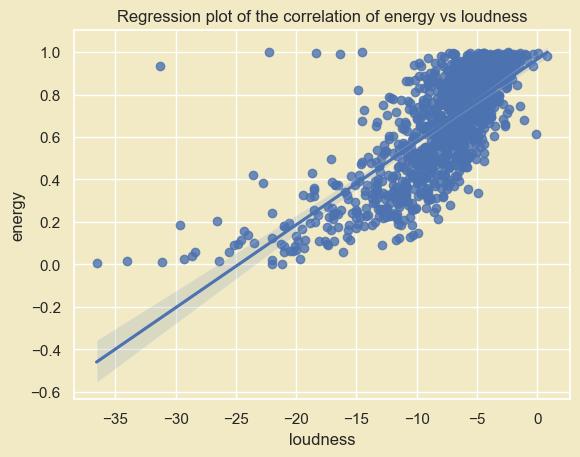

In [55]:
sample = df.sample(int(0.01 * len(df)))
sns.regplot(data=sample, y="energy", x="loudness", color="b")
plt.title("Regression plot of the correlation of energy vs loudness")
plt.show()

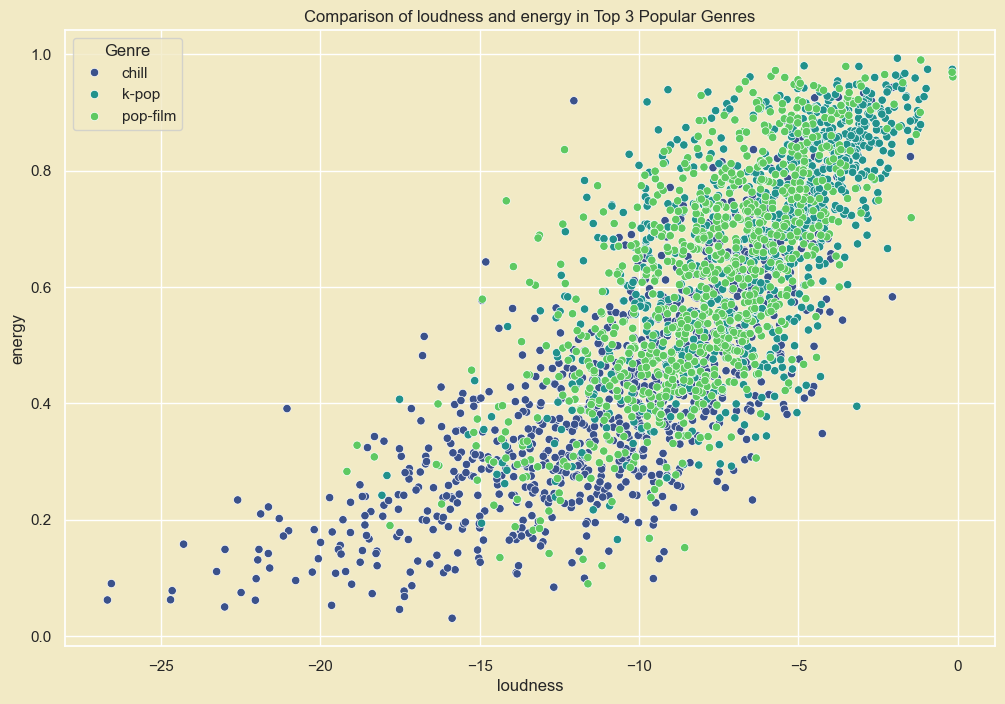

In [56]:
avg_popularity_by_genre = df.groupby('track_genre')['popularity'].mean().reset_index()
top3_popular_genres = avg_popularity_by_genre.nlargest(3, 'popularity')

top3_genre_data = df[df['track_genre'].isin(top3_popular_genres['track_genre'])]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='loudness', y='energy', hue='track_genre', data=top3_genre_data, palette='viridis')
plt.title('Comparison of loudness and energy in Top 3 Popular Genres')
plt.xlabel('loudness')
plt.ylabel('energy')
plt.legend(title='Genre')
plt.show()

##### Answering this question requires looking at it from various perspectives. For music listeners, the popularity score indicates their preferences. However, delving deeper into details reveals that the pop genre surpasses all others, especially in the top-ranking songs. It constitutes around 1/5 of the top songs.
##### Considering characteristics like live, loudness, and energy, there is an audience preference for live, energetic performances, as seen in genres like pop.
##### From an artist's standpoint, some may desire broader popularity, while others may choose to follow personal interests rather than trends.
##### Event organizers aim for lively and captivating shows to attract a large audience.

# How can we suggest songs based on a user's current listening preferences?

The goal is to recommend songs to users based on the similarity between songs, helping listeners discover music they might enjoy based on their preferences. We assume that if a user likes a particular song, they may also enjoy songs that are similar to it.

### Using Euclidean Distance as a Foundation

Use Euclidean distance to measure the similarity between songs. The smaller the Euclidean distance, the more similar two songs are from the perspective of the selected features.
Select k songs with the smallest distances. These are the songs that the system highly rates in similarity to the user's liked song.

Extract information such as song names and artists from the selected songs and return this information as recommendations for the user.

In [57]:
df = df.drop(['time_signature', 'key'], axis=1)
df.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,acoustic


In [58]:
df.drop_duplicates(subset=['track_id'], inplace=True)
df.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,acoustic


In [59]:
# To avoid the influence of different units of measurement, we need to normalize the data by these steps:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

numerical_cols = df.select_dtypes(include=np.number).columns
data_norm = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols, index=df['track_id'])

In [76]:
trackNameListened = "Knockin' On Heaven's Door"
track_id = df[(df['track_name'] == trackNameListened)][['track_id']]
track_id = track_id.values[0][0]

target_track = list(data_norm.loc[track_id])

In [72]:
data_result = pd.DataFrame()
data_result['euclidean'] = [distance.euclidean(obj, target_track) for index, obj in data_norm.iterrows()]
data_result['track_id'] = data_norm.index

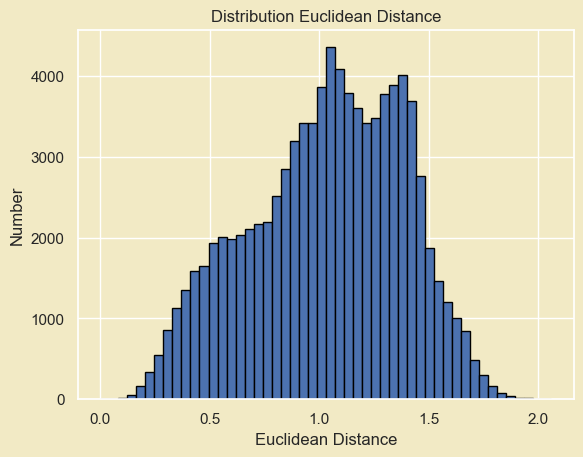

In [73]:
plt.hist(data_result['euclidean'], bins=50, edgecolor='black')

plt.xlabel('Euclidean Distance')
plt.ylabel('Number')

plt.title('Distribution Euclidean Distance')

plt.show()

In [74]:
data_rec = data_result.sort_values(by=['euclidean']).iloc[:6]

data_init = df.set_index(df.loc[:, 'track_id'])
track_list = pd.DataFrame()
for i in list(data_rec.loc[:, 'track_id']):
    if i in list(df.loc[:, 'track_id']):
        track_info = data_init.loc[[i], ['track_name', 'artists']]
        track_list = pd.concat([track_list, track_info], ignore_index=True)

In [75]:
recomended = track_list.values.tolist()
print(f"""You've just listened:  \n \t - {recomended[0][0]} - {recomended[0][1]} 
Now you may listen : 
\n \t - '{recomended[1][0]} - {recomended[1][1]}'
Or any of:
\n \t - '{recomended[2][0]} - {recomended[2][1]}' 
\n \t - '{recomended[3][0]} - {recomended[3][1]}'
\n \t - '{recomended[4][0]} - {recomended[4][1]}'
\n \t - '{recomended[5][0]} - {recomended[5][1]}'  """)

You've just listened:  
 	 - Amanda - Don Williams 
Now you may listen : 

 	 - 'A Flor Que A Gente Assopra - Almir Sater;Renato Teixeira'
Or any of:

 	 - 'Proibida Pra Mim - Zeca Baleiro' 

 	 - 'Main Ki Karaan? - Pritam;Sonu Nigam;Romy'

 	 - 'Mann Melo, Pt. 1 - Jasleen Royal;Siddharth Amit Bhavsar'

 	 - 'Grace - Laura Story'  


In [78]:
import pandas as pd
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

def extract_features(song_info):
    # This is a placeholder function. In reality, you'd use an audio analysis tool or API
    # to extract these features from the audio file or from a music database
    return {
        'danceability': 0.732,
        'energy': 0.856,
        'loudness': -2.2,
        'mode': 0,
        'speechiness': 0.0929,
        'acousticness': 0.0828,
        'instrumentalness': 0,
        'liveness': 0.323,
        'valence': 0.771,
        'tempo': 145.034,
    }

def add_new_song(df, data_norm, song_info):
    # Extract features for the new song
    new_features = extract_features(song_info)
    
    # Create a new row for the dataframe
    new_row = pd.DataFrame({
        'track_id': [song_info['track_id']],
        'artists': [song_info['artists']],
        'album_name': [song_info['album_name']],
        'track_name': [song_info['track_name']],
        **new_features
    })
    
    # Add the new row to the dataframe
    df_updated = pd.concat([df, new_row], ignore_index=True)
    
    # Normalize the features of the new song
    features_to_normalize = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df_updated[features_to_normalize])
    
    # Create a new normalized dataframe including the new song
    data_norm_updated = pd.DataFrame(normalized_features, columns=features_to_normalize, index=df_updated['track_id'])
    
    return df_updated, data_norm_updated

def get_recommendations(track_id, df, data_norm, n_recommendations=5):
    try:
        # Get the normalized data for this track
        target_track = data_norm.loc[track_id].values
        
        # Calculate distances
        data_result = pd.DataFrame()
        data_result['euclidean'] = [distance.euclidean(row.values, target_track) for _, row in data_norm.iterrows()]
        data_result['track_id'] = data_norm.index
        
        # Sort and get top recommendations (excluding the original track)
        data_rec = data_result[data_result['track_id'] != track_id].sort_values(by=['euclidean']).iloc[:n_recommendations]
        
        # Get track info
        data_init = df.set_index('track_id')
        recommendations = []
        for i in data_rec['track_id']:
            if i in df['track_id'].values:
                track_info = data_init.loc[i, ['track_name', 'artists']]
                recommendations.append(track_info.tolist())
        
        return recommendations
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

# Usage example
new_song_info = {
    'track_id': '2tOOcDDYkh0PSjr6GwPEAJ',
    'artists': 'MAX',
    'album_name': 'Love Me Less (feat. Quinn XCII)',
    'track_name': 'Love Me Less (feat. Quinn XCII)'
}

# Add the new song to the dataset
df_updated, data_norm_updated = add_new_song(df, data_norm, new_song_info)

# Get recommendations for the new song
recommendations = get_recommendations(new_song_info['track_id'], df_updated, data_norm_updated)

if recommendations:
    print(f"Based on '{new_song_info['track_name']}' by {new_song_info['artists']}, you may like:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. '{rec[0]}' by {rec[1]}")
else:
    print("No recommendations available.")

Based on 'Love Me Less (feat. Quinn XCII)' by MAX, you may like:
1. 'Kokoroyohou' by Eve
2. 'Mundo de Ilusões - Ao Vivo' by Gusttavo Lima
3. 'Links, Rechts, Voor, Achteren' by Marco Kraats;Diego
4. 'Pietro Lombaaadi' by Tim Toupet;Lorenz Büffel
5. 'Pietro Lombaaadi' by Tim Toupet;Lorenz Büffel
